<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Normalization, Resizing, Rescaling,\
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast,\
    Layer, Dense, Embedding, Input, LayerNormalization, MultiHeadAttention,\
    Add, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,\
    SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


Pour mes premiers tests, j'utilise le jeu de données réduit issu du projet précédent, comportant des photos de 12 races de chiens.

In [3]:
dataset_12 = "./images_12/"
width, height = 224, 224
input_shape = (width, height, 3)
batch_size = 256
train_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
class_names = train_12.class_names
num_classes = len(class_names)
print(class_names)

Found 2648 files belonging to 12 classes.
Using 2119 files for training.
Found 2648 files belonging to 12 classes.
Using 529 files for validation.
['n02085936-Maltese_dog', 'n02086240-Shih_Tzu', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02092002-Scottish_deerhound', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02110806-basenji', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02112018-Pomeranian']


In [4]:
def concat_batchs(dataset):
  x_ds = None
  y_ds = None
  for image_batch, labels_batch in tqdm(dataset):
      if x_ds == None:
          x_ds = image_batch
          y_ds = labels_batch
      else:
          x_ds = tf.concat(axis=0, values = [x_ds, image_batch])
          y_ds = tf.concat(axis=0, values = [y_ds, labels_batch])
  return (x_ds, y_ds)

(x_train, y_train) = concat_batchs(train_12)
(x_test, y_test) = concat_batchs(val_12)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

100%|██████████| 3/3 [00:43<00:00, 14.64s/it]

x_train shape: (2119, 224, 224, 3) - y_train shape: (2119,)
x_test shape: (529, 224, 224, 3) - y_test shape: (529,)


Configuration des hyper-paramètres

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Préparation de la data augmentation

In [12]:
data_augmentation = Sequential(
    [
        Normalization(),
        Resizing(image_size, image_size),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.02),
        RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implémentation d'un perceptron multi-couches (multilayer perceptron - MLP)

In [34]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [16]:
class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Affiche les patches sur une première image

In [21]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


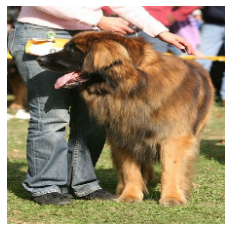

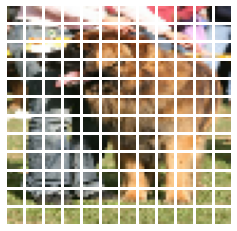

In [22]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [25]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [32]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = Dense(num_classes)(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    return model

Compile, train, and evaluate the mode

In [42]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            SparseCategoricalAccuracy(name="accuracy"),
            SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
8/8 [==============================] - 18s 578ms/step - loss: 5.3930 - accuracy: 0.1175 - top-5-accuracy: 0.4772 - val_loss: 2.5175 - val_accuracy: 0.1604 - val_top-5-accuracy: 0.5660
Epoch 2/100
8/8 [==============================] - 2s 277ms/step - loss: 2.8253 - accuracy: 0.1458 - top-5-accuracy: 0.5354 - val_loss: 2.3786 - val_accuracy: 0.1509 - val_top-5-accuracy: 0.5896
Epoch 3/100
8/8 [==============================] - 2s 276ms/step - loss: 2.5591 - accuracy: 0.1652 - top-5-accuracy: 0.5831 - val_loss: 2.3955 - val_accuracy: 0.1179 - val_top-5-accuracy: 0.6179
Epoch 4/100
8/8 [==============================] - 3s 388ms/step - loss: 2.4093 - accuracy: 0.1820 - top-5-accuracy: 0.6125 - val_loss: 2.3069 - val_accuracy: 0.2075 - val_top-5-accuracy: 0.6745
Epoch 5/100
8/8 [==============================] - 2s 280ms/step - loss: 2.3479 - accuracy: 0.2045 - top-5-accuracy: 0.6644 - val_loss: 2.3231 - val_accuracy: 0.1368 - val_top-5-accuracy: 0.6557
Epoch 6/100
8/8 [=======